![Nearly-New-Nautical (1)](Nearly-New-Nautical%20(1).jpg)
_Image generated with Stability.ai_
# Nearly New Nautical 🛥️
Nearly New Nautical is an online marketplace where users can advertise and sell their used boats. The platform collects a variety of information about the boats listed, which can be leveraged to better understand what drives customer engagement. <br>
<br>
Boats that get lots of views bring more traffic to the website, and more potential customers.
To boost traffic to the website, the product manager wants to prevent listing boats that do
not receive many views.

## Objective
The project aims to develop a predictive model that can forecast the number of views a listing would receive based on a boat's features. The intent is to use these insights to prevent listings that receive a low amount of veiw and thereby optimize the overall engagement on the website.

## Success Criteria
The product manager would consider using your model if, on average, the predictions are
within 50% of the actual number of views a listing receives.

### TL;DR

The developed **Random Forest** model predicts listing views with **44%** mean absolute precentage error (MAPE), meeting the key business criterion. This enables identifying unattractive or uncompetitive boat listings to optimize website engagement and sales.

The full report provides additional details on the modeling process, feature importance analysis, and recommendations. You can also find an extended summary at the end. (Use the outline to navigate)

# 1. Data Import and Validation 📑✅
The dataset we where given had these features:
| Column Name                 | Type      | Details                                                      |
|-----------------------------|-----------|--------------------------------------------------------------|
| Price                       | Character | Boat price listed in different currencies (e.g. EUR, £, CHF etc.) on the website |
| Boat Type                   | Character | Type of the boat                                  |
| Manufacturer                | Character | Manufacturer of the boat                          |
| Type                        | Character | Condition of the boat and engine type (e.g. Diesel, Unleaded, etc.) |
| Year Built                  | Numeric   | Year of the boat built                              |
| Length                      | Numeric   | Length in meter of the boat                         |
| Width                       | Numeric   | Width in meter of the boat                          |
| Material                    | Character | Material of the boat (e.g. GRP, PVC, etc.)        |
| Location                    | Character | Location of the boat is listed                    |
| Number of views last 7 days | Numeric   | Number of the views of the list last 7 days         |

## 1.1 Data Importing 📑
First, we import the necessary libraries for data manipulation and visualization, and then load the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Set seaborn as style
sns.set()

#Import the data into a DataFrame
boat_df = pd.read_csv('boat_data.csv')

boat_df.head()

,Price,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days
0,CHF 3337,Motor Yacht,Rigiflex power boats,new boat from stock,2017,4.00,1.90,NaN,Switzerland,226
1,EUR 3490,Center console boat,Terhi power boats,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany,75
2,CHF 3770,Sport Boat,Marine power boats,new boat from stock,0,3.69,1.42,Aluminium,Switzerland,124
3,DKK 25900,Sport Boat,Pioner power boats,new boat from stock,2020,3.00,1.00,NaN,Denmark,64
4,EUR 3399,Fishing Boat,Linder power boats,new boat from stock,2019,3.55,1.46,Aluminium,Germany,58


## 1.2 Data Type Validation ✅
To ensure usability we have to ensure that the data in the boat_df follows the feature recuierments given in the table above.


In [2]:
boat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Price                        9888 non-null   object 
 1   Boat Type                    9888 non-null   object 
 2   Manufacturer                 8550 non-null   object 
 3   Type                         9882 non-null   object 
 4   Year Built                   9888 non-null   int64  
 5   Length                       9879 non-null   float64
 6   Width                        9832 non-null   float64
 7   Material                     8139 non-null   object 
 8   Location                     9852 non-null   object 
 9   Number of views last 7 days  9888 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 772.6+ KB


All the data types are correct according to the inittial table, however we can already see that we will have to transform some features before modeling. E.g. the Price feature should be transformed into a numeric type, with one commen currency. But before all that let us do some data cleaning as we can see some is missing.

# 2. Data Cleaning 🧹
To ensure that we do not make the mistake of "garbage in garbage out" with our model we need to first check for any inconsistencies in our data. This includes  missing values, duplicates, wrong inputs and outliers.

## 2.1 Discover Missing Values🕳️

In [3]:
# Check for missing values
null = boat_df.isnull().sum()

# Check for duplicates
dup = boat_df.duplicated().sum()

# Check for distinct values in object types
distinct = boat_df.select_dtypes(include='object').nunique()

print(f"Dupclicates: {dup} \n \n Missing values: \n {null} \n \n Distinct values: \n {distinct}")

Dupclicates: 0 
 
 Missing values: 
 Price                             0
Boat Type                         0
Manufacturer                   1338
Type                              6
Year Built                        0
Length                            9
Width                            56
Material                       1749
Location                         36
Number of views last 7 days       0
dtype: int64 
 
 Distinct values: 
 Price           3182
Boat Type        126
Manufacturer     910
Type              24
Material          11
Location         115
dtype: int64


We can check the pattern of the missing data using msno.

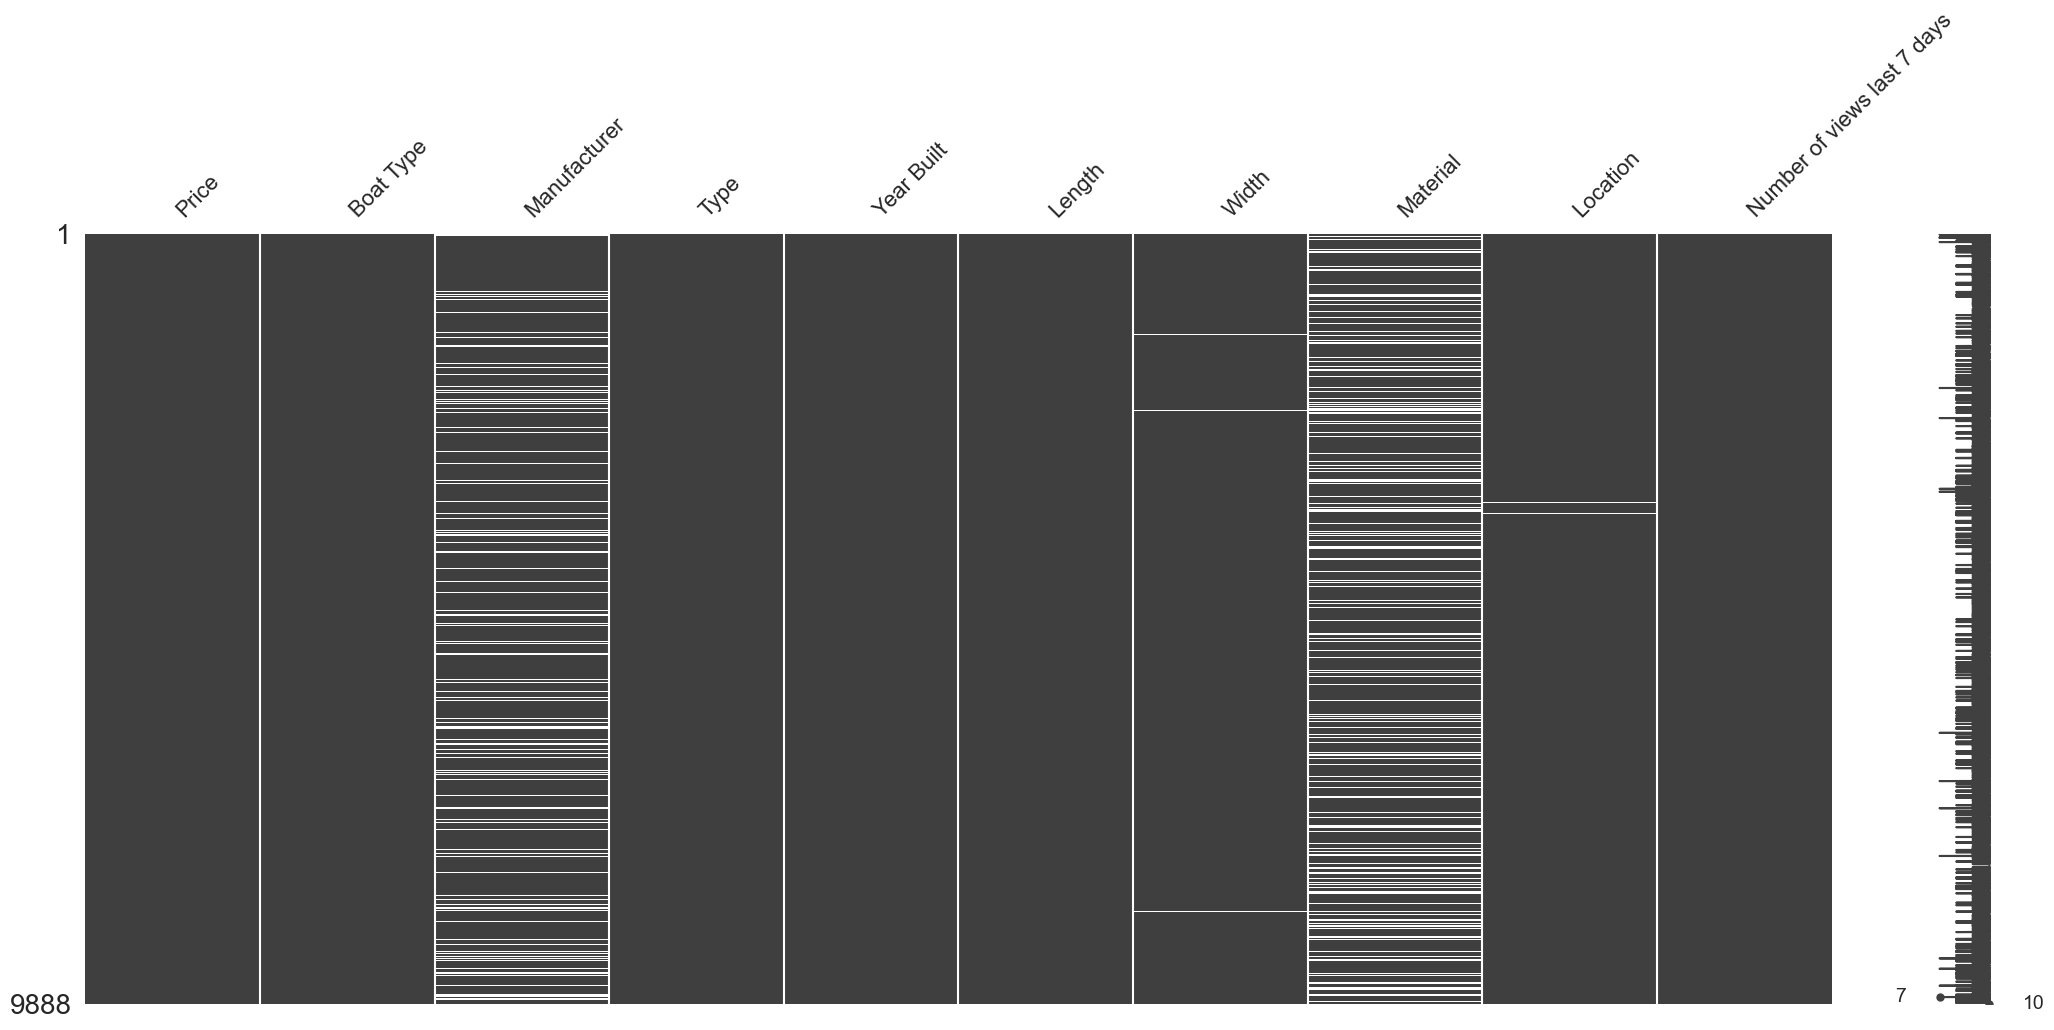

In [4]:
import missingno as msno

# data is your DataFrame
msno.matrix(boat_df)
plt.show()

In [5]:
for col in boat_df.select_dtypes(include='object').columns:
    if col != 'Price':
        print(boat_df[col].value_counts())

Motor Yacht                        2720
Sport Boat                         1407
Flybridge                          1194
Trawler                             679
Pilothouse                          613
                                   ... 
Bowrider,Motor Yacht,Sport Boat       1
Sport Boat,Working Boat               1
Classic,Motor Yacht,Sport Boat        1
Motor Yacht,Wakeboard/Wakesurf        1
Classic,Runabout,Trawler              1
Name: Boat Type, Length: 126, dtype: int64
BÃ©nÃ©teau power boats         631
Jeanneau power boats           537
Sunseeker power boats          383
Princess power boats           241
Sea Ray power boats            239
                              ... 
Aegean Yachts power boats        1
ISA Yachts power boats           1
Couach power boats               1
Perini Navi Spa power boats      1
Hunter power boats               1
Name: Manufacturer, Length: 910, dtype: int64
Used boat,Diesel                4140
Used boat,Unleaded              1686
Used boat   

**Missing Values** 🕳️: <br>
We find nulls in 'Manufacturer', 'Condition', 'Length', 'Width', 'Material' and 'Location'.

**Duplicates** 👥: <br>
No duplicate rows.

**Cardinality** 🔢: <br>
Some features have high cardinality, including 'Boat Type', 'Manufacturer' and 'Location'.

### 2.1.1 Categories

Digging a bit deeper into the data issues:

**Boat Type** - Most listings are in the top five categories. However the reason we have so many types seems to be due to that some boats are added to more than one category. Creating unncessary distinct categories.

**Manufactuar** - This seems to be valid, there are just a lot of manufactuars, most seem to end with 'power boats' tho, this might be redundant information.

**Type** - This seems like we can split into two features, one for 'Condition' and one for 'Fule Type'

**Location** - This seems to be correct, there is just a lot of countries that lists only 1 boat. Maybe we can consolidate it into an 'Others' category.

### 2.1.2 Numeric

In [6]:
boat_df.describe()


,Year Built,Length,Width,Number of views last 7 days
count,9888.000000,9879.000000,9832.000000,9888.000000
mean,1893.192860,11.570017,3.520124,149.160801
std,460.201582,6.002820,1.220534,151.819752
min,0.000000,1.040000,0.010000,13.000000
25%,1996.000000,7.470000,2.540000,70.000000
50%,2007.000000,10.280000,3.330000,108.000000
75%,2017.000000,13.930000,4.250000,172.000000
max,2021.000000,100.000000,25.160000,3263.000000


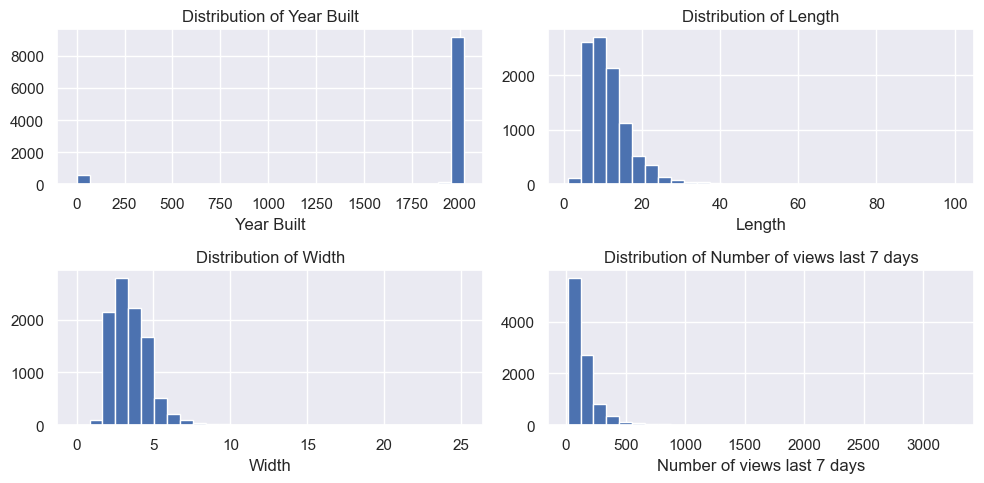

In [7]:
# Selecting columns with integer and float data types
int_cols = boat_df.select_dtypes(include=['int64', 'float64']).columns

# Creating a figure with 2 rows and 2 columns
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

# Looping through each integer column
for i, col in enumerate(int_cols):
    row = i // 2
    pos = i % 2
    # Creating a histogram of the current column with 30 bins
    axs[row, pos].hist(boat_df[col], bins=30)
    axs[row, pos].set_xlabel(col)
    axs[row, pos].set_title(f'Distribution of {col}')

# Adjusting the layout of the subplots to fit the figure
plt.tight_layout()
plt.show()

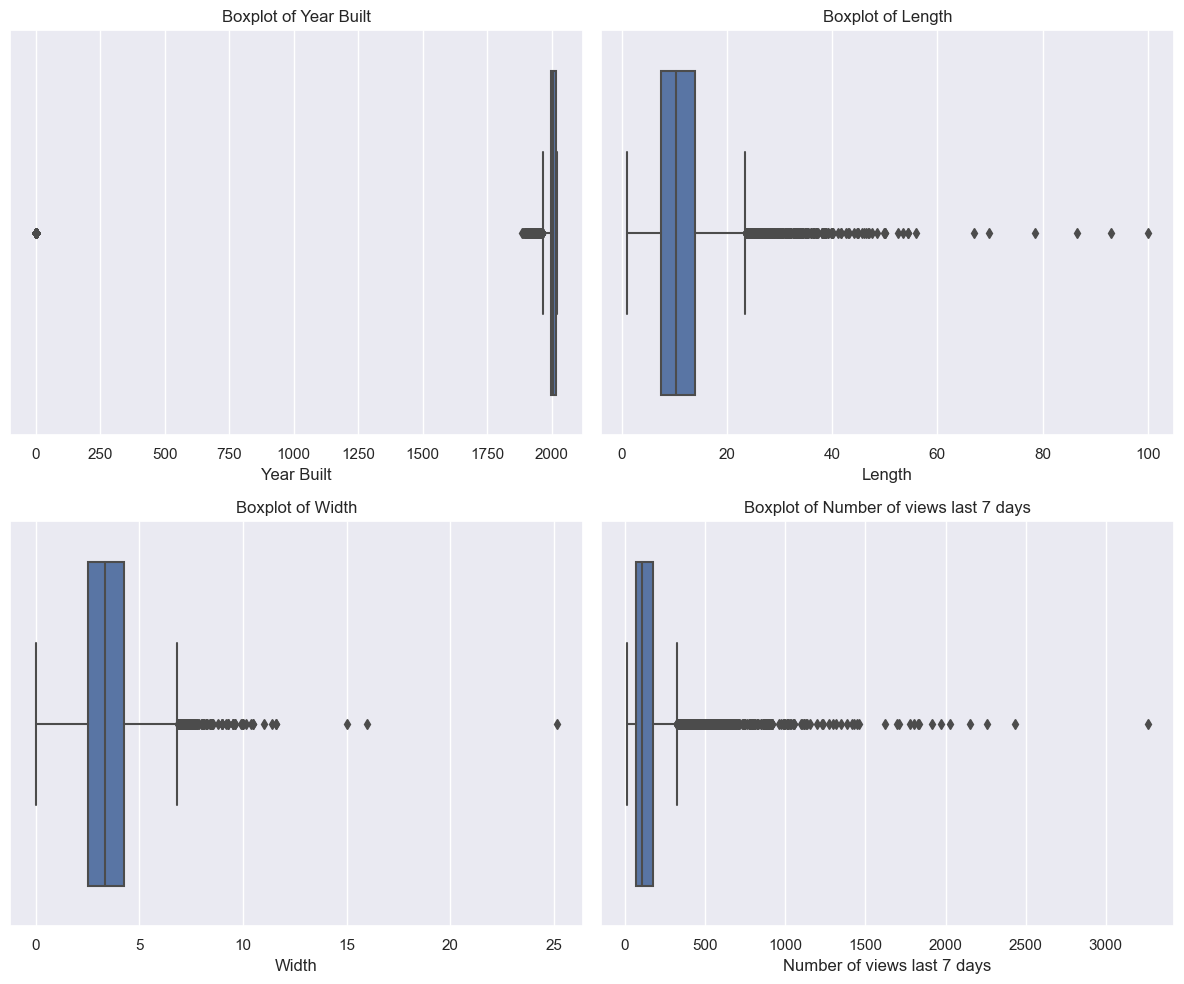

In [8]:
# Creating a figure with 2 rows and 2 columns
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

for i, col in enumerate(int_cols):
    row = i // 2
    pos = i % 2
    #Creating a boxplot of current column
    sns.boxplot(x=boat_df[col].dropna(), ax=axs[row, pos])
    axs[row, pos].set_xlabel(col)
    axs[row, pos].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

**Outliers** 🚨: <br>
Numeric columns like 'Year Built', 'Length' and 'Views' contain outliers.

First **Year Built** has some data points that are put in as 0. It is higly unlikly that anyone is selling a boat that is over 2000 years old, so this should be dealt with.

Secondly **Lenght** the difference between the 75% and the max is 86m wich means we have a lot of outliers.<br> 
Same goes for **Width**, here we also see a min of 0,01m which maybe is a kajak, or a unlikly small motor boat.

Again for **views** the gape is huge between the 75% line and max value respectivly 172 and 3000+.

## 2.2 Cleaning Categorical Variables 🪄

We first create a copy of the original DataFrame so we always have the original data.

In [9]:
mod_boat_df = boat_df.copy()

Next we replace missing values in categorical features like 'Manufacturer', 'Material', and 'Location'. We replace these missing values with a placeholder 'Unknown'. This ensures that we do not run into issues with 'null' values. Later we will do some feature transformation to minimize the amount of 'Unkown' values. 

In [10]:
#Replace missing values with 'Unknown'
replace_missing_category = mod_boat_df[['Manufacturer', 'Material', 'Location', 'Type']]

for col in replace_missing_category:
    mod_boat_df[col].fillna('Unknown', inplace=True)

On inspecting the 'Manufacturer' feature earlier, we noted a common ending 'power boats' present in a majority of manufacturers. Turns out this is ending is present in all manufacturer names. This is this as redundant information and we can remove it for a cleaner more readable look.

In [11]:
# Count unique manufacturers ending with 'power boats'
power_boats_count = len(boat_df[boat_df['Manufacturer'].str.endswith('power boats', na=False)]['Manufacturer'].unique())

# Calculate the percentage of total manufacturers
total_manufacturers = len(boat_df['Manufacturer'].dropna().unique())
power_boats_percentage = (power_boats_count / total_manufacturers)

power_boats_percentage

1.0

In [12]:
# Remove 'power boats' from 'Manufacturer' 
mod_boat_df['Manufacturer'] = mod_boat_df['Manufacturer'].str.replace(' power boats', '', regex=False)

So based on the Materials a Manufacturer use we can infer that the 'Uknown' material is the same if the manufactuer only produces one type of material boat. This way we can get rid of some 'Unkown' values. More precisly we get to clean up 340 'Unknown' values by imputing their value.

In [13]:
# Identify the manufacturers that have 'Unknown' materials
unknown_material_manufacturers = mod_boat_df[mod_boat_df['Material'] == 'Unknown']['Manufacturer'].unique()

# Loop through these manufacturers
for manufacturer in unknown_material_manufacturers:
    # Identify the materials associated with this manufacturer in the observed data
    observed_materials = mod_boat_df[(mod_boat_df['Manufacturer'] == manufacturer) & (mod_boat_df['Material'] != 'Unknown')]['Material'].unique()
    
    # If there's only one observed material for this manufacturer, replace 'Unknown' with this material
    if len(observed_materials) == 1:
        mod_boat_df.loc[(mod_boat_df['Manufacturer'] == manufacturer) & (mod_boat_df['Material'] == 'Unknown'), 'Material'] = observed_materials[0]

In [14]:
mod_boat_df['Material'].value_counts()

GRP                    5769
Unknown                1409
PVC                    1135
Steel                   954
Wood                    241
Aluminium               236
Plastic                  91
Carbon Fiber             30
Thermoplastic            16
Hypalon                   5
Reinforced concrete       1
Rubber                    1
Name: Material, dtype: int64

The Location feature also had some mixed in charaters to clean this up I used some quick regex. This feature could be even more cleaned by matching cities with country. But I decided not to do this, later you will see why. 

In [15]:
# Get clean names
mod_boat_df['Location'] = mod_boat_df['Location'].str.replace('[Ã]', 'a', regex=True)
mod_boat_df['Location'] = mod_boat_df['Location'].str.replace('[^A-Za-z]', '', regex=True)

##  2.3 Cleaning Numeric Variables 🪄

Next let us deal with the numeric missing values. <br>
First, let us take the missing values in 'length' and 'width'. Since both of these have a lot of outliers we will use the median to replace the values. 

In [16]:
mod_boat_df['Length'] = mod_boat_df['Length'].fillna(mod_boat_df['Length'].median()) 
mod_boat_df['Width'] = mod_boat_df['Width'].fillna(mod_boat_df['Width'].median()) 

In [17]:
mod_boat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Price                        9888 non-null   object 
 1   Boat Type                    9888 non-null   object 
 2   Manufacturer                 9888 non-null   object 
 3   Type                         9888 non-null   object 
 4   Year Built                   9888 non-null   int64  
 5   Length                       9888 non-null   float64
 6   Width                        9888 non-null   float64
 7   Material                     9888 non-null   object 
 8   Location                     9888 non-null   object 
 9   Number of views last 7 days  9888 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 772.6+ KB


# 3. Feature Engeneering ⚙️
Now that we have gotten rid of there are no missing values we will deal with some data transformation and feature engeneering to get even better input to our model. <br>
## 3.1 Splitting _Type_ column into _Condition_ and _Fuel Type_
The first thing we will do is to create two seperate colums/features from the 'Type' column. This column contains both information about the _Condition_ of the boat and the _Fule Type_. We start by making a list of the conditions and fuel types Found in the data set, then entries in 'Type' are separated based on these lists. If an entry did not match any of the conditions or fuel types, it was labelled as 'Unknown'. This transformation reduced data complexity, ensures cleaner input to our model, and an additional feature.

In [18]:
conditions = ['Used boat', 'new boat from stock', 'new boat on order', 'Display Model']
fuel_types = ['Diesel', 'Unleaded', 'Electric', 'Gas', 'Hybrid', 'Propane']

# Create a new column for 'Condition'
mod_boat_df['Condition'] = mod_boat_df['Type'].apply(lambda x: x.split(',')[0] if x.split(',')[0] in conditions else 'Unknown')

# Create a new column for 'Fuel Type'
mod_boat_df['Fuel Type'] = mod_boat_df['Type'].apply(lambda x: x.split(',')[0] if x.split(',')[0] in fuel_types else (x.split(',')[1] if len(x.split(',')) > 1 else 'Unknown'))

mod_boat_df[['Condition', 'Fuel Type', 'Type']].value_counts()

Condition            Fuel Type  Type                        
Used boat            Diesel     Used boat,Diesel                4140
                     Unleaded   Used boat,Unleaded              1686
                     Unknown    Used boat                       1462
new boat from stock  Unleaded   new boat from stock,Unleaded    1107
                     Unknown    new boat from stock              665
                     Diesel     new boat from stock,Diesel       291
new boat on order    Unleaded   new boat on order,Unleaded       150
Display Model        Unleaded   Display Model,Unleaded            75
new boat on order    Unknown    new boat on order                 61
                     Diesel     new boat on order,Diesel          61
Unknown              Diesel     Diesel                            57
Used boat            Electric   Used boat,Electric                27
Unknown              Unleaded   Unleaded                          22
Display Model        Diesel     Display Mo

## 3.2 Fixing boats from year 0 and create 'Boat Age'
We found earlier that the build year of some boats had been listed as year 0. This is highly unlikly, so we will have to deal with this to get rid of the outliers. We can do this by using the median year from the 'Build Year' column, but a better approch and the one I will use is to infer that there is a correlation between Condition and Build Year. Therefor we will get better results using the median year based on condition (without 0 value outliers). <br>
We start by looking at the distribution.

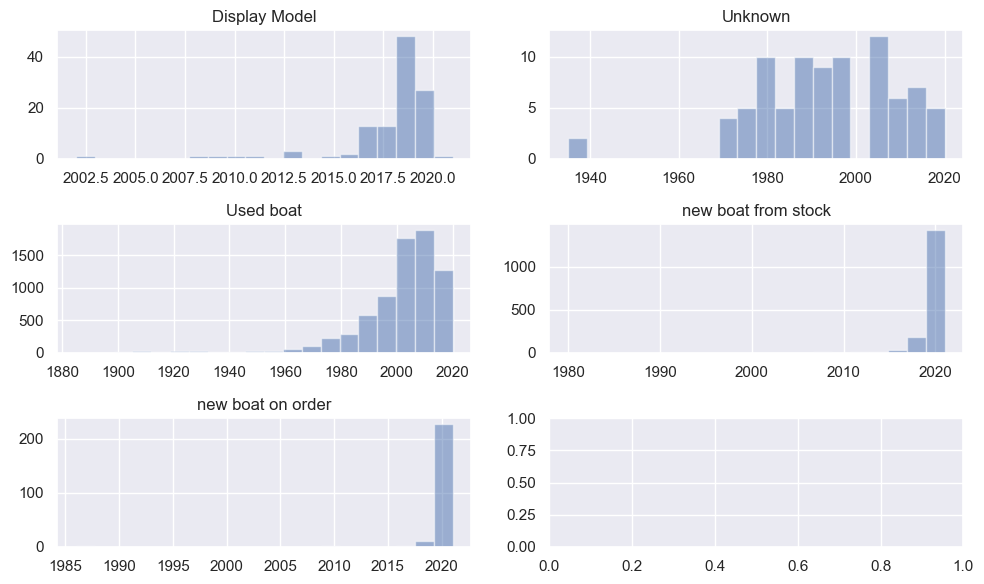

In [19]:
import matplotlib.pyplot as plt

df = mod_boat_df[['Year Built','Condition']]
df = df[df['Year Built']!= 0]

fig, axs = plt.subplots(figsize=(10, 6), nrows=3, ncols=2)

for ax, (condition, data) in zip(axs.flatten(), df.groupby('Condition')):
    ax.hist(data['Year Built'], bins=20, alpha=0.5)
    ax.set_title(condition)

plt.tight_layout()
plt.show()

In [20]:
# Transform 0s into meadian based on condition group (except for 'Unknown')
mod_boat_df['Year Built'] = mod_boat_df.groupby('Condition')['Year Built'].transform(lambda x: x.replace(0, x.median()) if x.name != 'Unknown' else x)

# Replace remaining 0s (which is now a singel 'Unknown' condition) with the overall median
mod_boat_df['Year Built'] = mod_boat_df['Year Built'].replace(0, mod_boat_df['Year Built'].median())

In [21]:
mod_boat_df.groupby('Condition')['Year Built'].describe()

,count,mean,std,min,25%,50%,75%,max
Condition,,,,,,,,
Display Model,119.0,2018.218487,2.636638,2002.0,2018.0,2019.0,2019.0,2021.0
Unknown,86.0,1993.337209,16.231857,1935.0,1982.0,1994.0,2006.0,2020.0
Used boat,7327.0,2001.128156,16.258955,1885.0,1996.0,2005.0,2010.0,2020.0
new boat from stock,2084.0,2019.152111,2.028929,1980.0,2019.0,2019.0,2020.0,2021.0
new boat on order,272.0,2019.867647,2.204687,1986.0,2020.0,2020.0,2020.0,2021.0


In [22]:
# Format Year Built to Date type
mod_boat_df['Year Built'] = pd.to_datetime(mod_boat_df['Year Built'], format='%Y').dt.date

mod_boat_df['Year Built']

0       2017-01-01
1       2020-01-01
2       2019-01-01
3       2020-01-01
4       2019-01-01
           ...    
9883    1987-01-01
9884    2019-01-01
9885    2020-01-01
9886    2018-01-01
9887    2019-01-01
Name: Year Built, Length: 9888, dtype: object

Becuse datetime data can be complex to deal with in many alogrithms I decided to create a Boat Age feature instead to get a numeric interpretation of the Yeat Built that will be more usefull in our models. 

In [23]:
mod_boat_df['Year Built'] = pd.to_datetime(mod_boat_df['Year Built'], errors='coerce').dt.year.astype(int)
mod_boat_df['Boat Age'] = 2023 - mod_boat_df['Year Built']

## 3.3 Create a single currency for Price
In our Price column, the prices are stored in differnt currencies, making it har to interperate the real differences in price. We need to transform this into a sigle category. We will use Euro as this is the most commen currency in our data set.

In [24]:
# Extract the currency from the Price column
mod_boat_df['Currency'] = mod_boat_df['Price'].str.extract('([A-Z$£€]+)')

# Get unique currencies
unique_currencies = mod_boat_df['Currency'].unique()

mod_boat_df['Currency'].value_counts()

EUR    8430
CHF     980
£       298
DKK     180
Name: Currency, dtype: int64

In [25]:
# Remove non-numeric characters from the Price column
mod_boat_df['Price'] = mod_boat_df['Price'].str.replace('[^\d.]', '', regex=True)

# Convert Price column to integer type
mod_boat_df['Price'] = mod_boat_df['Price'].astype(int)

mod_boat_df['Price']

0        3337
1        3490
2        3770
3       25900
4        3399
        ...  
9883     4900
9884     4516
9885     4499
9886     4300
9887     3780
Name: Price, Length: 9888, dtype: int64

In [26]:
# Create a dictionary to store the conversion rates
conversion_rates = {'DKK': 0.13, 'CHF': 1.02, '£': 1.16}

# Convert the prices to EUR
mod_boat_df['Price EUR'] = mod_boat_df.apply(lambda row: row['Price'] * conversion_rates[row['Currency']] if row['Currency'] in conversion_rates else row['Price'], axis=1)

mod_boat_df['Price EUR']

0       3403.74
1       3490.00
2       3845.40
3       3367.00
4       3399.00
         ...   
9883    4998.00
9884    4516.00
9885    4499.00
9886    4300.00
9887    3855.60
Name: Price EUR, Length: 9888, dtype: float64

Now we can drop the features we have replaced with new features.

In [27]:
# Drop the unused columns
mod_boat_df.drop(['Price', 'Currency','Type', 'Year Built'], axis=1, inplace=True)

mod_boat_df.head()

,Boat Type,Manufacturer,Length,Width,Material,Location,Number of views last 7 days,Condition,Fuel Type,Boat Age,Price EUR
0,Motor Yacht,Rigiflex,4.00,1.90,Unknown,Switzerland,226,new boat from stock,Unknown,6,3403.74
1,Center console boat,Terhi,4.00,1.50,Thermoplastic,Germany,75,new boat from stock,Unknown,3,3490.00
2,Sport Boat,Marine,3.69,1.42,Aluminium,Switzerland,124,new boat from stock,Unknown,4,3845.40
3,Sport Boat,Pioner,3.00,1.00,Plastic,Denmark,64,new boat from stock,Unknown,3,3367.00
4,Fishing Boat,Linder,3.55,1.46,Aluminium,Germany,58,new boat from stock,Unknown,4,3399.00


# 4. Exploratory Analysis

To explor the cleaned data I decided to use _pandas_profiling_ this creates a report for all our columns as well as automaticlly alert about issues in the data. It is an effective way of visulizing and explor the data without having to write a lot of code.

In [58]:
from pandas_profiling import ProfileReport

profile = ProfileReport(mod_boat_df, title="Profiling Report")

profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 5. Feature Transformation 👨🏻‍🔧
After exploring the data we discovered a couple issues. We still have some features with very high cardinality (_Boat Type, Location, Manufacturer_) . This will create problems when we try to build the model later. <br> We also have some features with very high correlation (_Weight & Lenght_). 

To deal with this I will do a bit more cleaning and some feature engeenering. Because most of our data also is highly skeewd I will log transform the numeric features to normalize the distribution. 

## 5.1 Reduce cardinality of 'Boat Type', 'Location' and 'Manufacturer'

Boat Type has 126 distinct values, partilly becuse some boats have been assigned more than one type in a , seperated list. To reduce this I decided to use the top 10 Boat Types and add an Other category. This will reduce each listing to be in a single category and reduce the number of categories to 11.

In [29]:
import re

def categorize_boat_type(boat_type):
    top_boat_type = ['Motor Yacht', 'Sport Boat', 'Flybridge', 'Trawler', 'Pilothouse', 'Cabin Boat', 'Hardtop', 'Center console boat', 'Bowrider', 'Deck Boat']
    
    # Check if the boat type contains multiple types separated by comma
    if ',' in boat_type:
        types = re.split(r'\s*,\s*', boat_type)
        
        # Check if any of the types is in the top boat types
        for t in types:
            if t in top_boat_type:
                return t
        
        # If none of the types is in the top boat types, return 'Other'
        return 'Other'
    
    # If the boat type is not a comma-separated list, check if it is in the top boat types
    if boat_type in top_boat_type:
        return boat_type
    
    # If the boat type is not in the top boat types, return 'Other'
    return 'Other'

mod_boat_df['Boat Type'] = mod_boat_df['Boat Type'].apply(lambda x: categorize_boat_type(x))

In [30]:
mod_boat_df['Boat Type'].value_counts()

Motor Yacht            2771
Sport Boat             1448
Flybridge              1212
Other                  1011
Trawler                 686
Cabin Boat              654
Pilothouse              616
Hardtop                 515
Center console boat     377
Bowrider                310
Deck Boat               288
Name: Boat Type, dtype: int64

Next we will reduce the cardinality of the Location feature. This had 116 distinct values, but most are in the top ten. By reducing the categories to values with at least 1% and replacing the rest with Other we get 11 categories. 

In [31]:
# Find categories with less than 1% of total rows
value_counts = mod_boat_df['Location'].value_counts(normalize=True)
less_than_1_percent = value_counts[value_counts < 0.01].index

# Replace categories with 'Other'
mod_boat_df.loc[mod_boat_df['Location'].isin(less_than_1_percent), 'Location'] = 'Other'

mod_boat_df['Location'].value_counts()

Germany        1914
Italy          1793
France         1229
Switzerland    1112
Netherlands    1056
Croatia         811
Other           726
Spain           702
United          238
Denmark         172
Portugal        135
Name: Location, dtype: int64

To deal with Manufacturer that has 911 distinct values would be a hugh job so I have decided to drop this feature. 

## 5.2 Create new features

Since Width and Length was highly correlated I decided to combine them into one Size feature.

In [32]:
mod_boat_df['Size'] = mod_boat_df['Width'] * mod_boat_df['Length']

## 5.3 Normalize numeric features
Because our numeric features are so skeewd I decided to log transform them to make them closer to normal distributed. 

In [33]:
from scipy import stats

# Let us normalize the data
feature_to_transform = ['Size','Boat Age', 'Price EUR']

for feature in feature_to_transform:
    mod_boat_df[feature +'_log'] = np.log(mod_boat_df[feature] + 1)

After all this it is time to drop all the columns we no longer need.

In [34]:
mod_boat_df = mod_boat_df.drop(['Length', 'Width', 'Size','Boat Age','Price EUR', 'Manufacturer'], axis = 1)

In [35]:
mod_boat_df

,Boat Type,Material,Location,Number of views last 7 days,Condition,Fuel Type,Size_log,Boat Age_log,Price EUR_log
0,Motor Yacht,Unknown,Switzerland,226,new boat from stock,Unknown,2.151762,1.945910,8.132924
1,Center console boat,Thermoplastic,Germany,75,new boat from stock,Unknown,1.945910,1.386294,8.157944
2,Sport Boat,Aluminium,Switzerland,124,new boat from stock,Unknown,1.830948,1.609438,8.254893
3,Sport Boat,Plastic,Denmark,64,new boat from stock,Unknown,1.386294,1.386294,8.122074
4,Other,Aluminium,Germany,58,new boat from stock,Unknown,1.821804,1.609438,8.131531
...,...,...,...,...,...,...,...,...,...
9883,Sport Boat,Unknown,Switzerland,1116,Used boat,Unleaded,2.795573,3.610918,8.516993
9884,Sport Boat,GRP,Germany,94,new boat from stock,Unknown,2.080141,1.609438,8.415603
9885,Sport Boat,GRP,Germany,354,new boat from stock,Unleaded,2.188296,1.386294,8.411833
9886,Other,Unknown,Italy,266,new boat from stock,Unknown,2.225628,1.791759,8.366603


## 5.4 Encoding & Scaling 📏
To make sure the models can work with our data we have to encode the categorical data. I will also scale the numeric values to ensure that one feature is not assumed to carry more value than others. 

In [70]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd

ohe = OneHotEncoder(sparse=False)
encoded_features = ohe.fit_transform(mod_boat_df.select_dtypes(include=['object']))
encoded_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names(mod_boat_df.select_dtypes(include=['object']).columns))

scaler = StandardScaler()
scaled_features = scaler.fit_transform(mod_boat_df.select_dtypes(exclude=['object']))
scaled_df = pd.DataFrame(scaled_features, columns=mod_boat_df.select_dtypes(exclude=['object']).columns)

processed_df = pd.concat([encoded_df, scaled_df], axis=1)

processed_df.shape

(9888, 50)

In [71]:
processed_df['Number of views last 7 days'] = mod_boat_df['Number of views last 7 days']

# 6. Model Building 🏗️
Now we can start building models. We will start by splitting our data set into a training and test set.

Important to note here is that I log transform our target as well here, since it is right skeewd.

In [72]:
from sklearn.model_selection import train_test_split

TO_PREDICT = 'Number of views last 7 days'                                                  
TEST_SIZE = .30                                                             

def split_in_X_y(processed_df):                                                              
    X = processed_df.loc[:, processed_df.columns != TO_PREDICT]
    y = processed_df[TO_PREDICT]
    y = np.log(y)
    
    return X,y

X,y = split_in_X_y(processed_df)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = TEST_SIZE, random_state=42) 

Next we import the models we want to test.

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics


#Create a list with all the models
model_pipeline = []
model_pipeline.append(KNeighborsRegressor())
model_pipeline.append(DecisionTreeRegressor(random_state=42))
model_pipeline.append(LinearRegression())
model_pipeline.append(SVR())
model_pipeline.append(RandomForestRegressor(random_state=42))

Then we test them. I've decided to make sort of a pipe so we can quickly test multiple models to get a feel of what might work.

In [73]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

#Create the list of models and the accuracy of each model
model_list = ['KNN', 'Decision Tree', 'Linear Regression', 'SVM', 'Random Forest']
training_r2_score_list = []
mape_list = []
mean_cross_val_mse=[]

for model in model_pipeline:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    training_r2_score_list.append(model.score(X_train, y_train))  # R2 score for training data
    mape_list.append(metrics.mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred)))
    
    # Negative Mean Squared Error for cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_cross_val_mse.append(-scores.mean())

# Compare the performance of the models in a dataframe
result_df = pd.DataFrame({'Model': model_list, 'Training R2 Score': training_r2_score_list, 'MAPE': mape_list, 'Cross Validation MSE': mean_cross_val_mse})
result_df

,Model,Training R2 Score,MAPE,Cross Validation MSE
0,KNN,0.568707,0.480151,3.118698e-01
1,Decision Tree,0.998398,0.712390,5.250934e-01
2,Linear Regression,0.363345,0.492135,9.100345e+20
3,SVM,0.546230,0.441030,2.629261e-01
4,Random Forest,0.918989,0.453241,2.771314e-01


From the result we can see that most models do a good job within our sucess criteria of MAPE < 0,5. 

Decision Tree is the only model not meeting this target, however with no tuning it is likly to have overfitted on the training data.
The second anomalie is the high MSE of the linear regression model suggesting it does not generlize well, as our previous analisys have showed there are very few linear relationships with the target value so this might be why. 

Next we will tune hyperparameters to see if we can improve the models.

## 6.1 KNN 🏘️
I will use Grid Serach to find the optimal hyperparameters.

In [74]:

#hyperparameter tuning for KNN
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their possible values
'''param_grid = {
    'n_neighbors': list(range(3, 20)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Create a KNN regressor
knn = KNeighborsRegressor()

# Create a grid search object with parallel execution (using all CPU cores)
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation negative MSE:", grid_search.best_score_)'''

'param_grid = {\n    \'n_neighbors\': list(range(3, 20)),\n    \'weights\': [\'uniform\', \'distance\'],\n    \'metric\': [\'euclidean\', \'manhattan\', \'minkowski\']\n}\n\n# Create a KNN regressor\nknn = KNeighborsRegressor()\n\n# Create a grid search object with parallel execution (using all CPU cores)\ngrid_search = GridSearchCV(knn, param_grid, cv=5, scoring=\'neg_mean_squared_error\', n_jobs=-1)\n\n# Fit the grid search object to the data\ngrid_search.fit(X_train, y_train)\n\n# Print the best hyperparameters\nprint("Best parameters: ", grid_search.best_params_)\nprint("Best cross-validation negative MSE:", grid_search.best_score_)'

After finding the optimal hyperparameters we train and test a new KNN model.

In [75]:
from sklearn.metrics import mean_squared_error

# Train the KNN model with the best hyperparameters
best_knn = KNeighborsRegressor(metric='manhattan', n_neighbors=19, weights='distance')
best_knn.fit(X_train, y_train)

# Predict on the test set
y_pred = best_knn.predict(X_test)

#Calculate the R2-score on the training set
r2_score= best_knn.score(X_train, y_train)
print(f"Training R2 Score: {r2_score}" )

# Calculate the MSE on the test set
mse = mean_squared_error(np.exp(y_test), np.exp(y_pred))
print(f"Test MSE: {mse}")

# Calculate the RMSE on the test set
rmse = np.sqrt(mse)
print(f"Test RMSE: {rmse}")

# Calculate the MAPE on the test set
mape = metrics.mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred))
print(f"Test MAPE: {mape}")

scores = cross_val_score(best_knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
scores = -scores.mean()
print(f"Cross_val MSE: {scores}")

Training R2 Score: 0.9983980192697258
Test MSE: 17415.74105482556
Test RMSE: 131.9687124087583
Test MAPE: 0.44815976927054046
Cross_val MSE: 0.28429853144437706


## 6.2 SVM 🤖
Next is tuning the SVM model, this can take a lot of time so I have not chosen a lot of parameters here.

In [44]:
'''# Define the hyperparameters and their possible values
param_grid = {
    'C': [0.5, 1, 2, 3],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

# Create an SVR regressor
svm = SVR()

# Create a grid search object with parallel execution
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation negative MSE:", grid_search.best_score_)'''

'# Define the hyperparameters and their possible values\nparam_grid = {\n    \'C\': [0.5, 1, 2, 3],\n    \'kernel\': [\'linear\', \'poly\', \'rbf\', \'sigmoid\'],\n}\n\n# Create an SVR regressor\nsvm = SVR()\n\n# Create a grid search object with parallel execution\ngrid_search = GridSearchCV(svm, param_grid, cv=5, scoring=\'neg_mean_squared_error\', n_jobs=-1)\n\n# Fit the grid search object to the data\ngrid_search.fit(X_train, y_train)\n\n# Print the best hyperparameters\nprint("Best parameters: ", grid_search.best_params_)\nprint("Best cross-validation negative MSE:", grid_search.best_score_)'

After finding the optimal hyperparameters we train and test a new SVM model.

In [45]:
# Train the SVM model with the best hyperparameters
best_svm = SVR(C =0.5, kernel= 'rbf')
best_svm.fit(X_train, y_train)

# Predict on the test set
y_pred = best_svm.predict(X_test)

#Calculate the R2-score on the training set
r2_score= best_svm.score(X_train, y_train)
print(f"Training R2 Score: {r2_score}" )

# Calculate the MSE on the test set
mse = mean_squared_error(np.exp(y_test), np.exp(y_pred))
print(f"Test MSE: {mse}")

# Calculate the RMSE on the test set
rmse = np.sqrt(mse)
print(f"Test RMSE: {rmse}")

# Calculate the MAPE on the test set
mape = metrics.mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred))
print(f"Test MAPE: {mape}")

scores = cross_val_score(best_knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
scores = -scores.mean()
print(f"Cross_val MSE: {scores}")



Training R2 Score: 0.5237864120408109
Test MSE: 16296.724295935312
Test RMSE: 127.65862405625133
Test MAPE: 0.4393722969294954
Cross_val MSE: 0.28429853144437706


## 6.3 Decision Tree 🌳
Tuning the Decision Tree is pretty quick so here we can test many parameters.

In [46]:
'''# Define the hyperparameters and their possible values
param_grid = {
    'max_depth': [5, 6, 7, 8, 9],
    'min_samples_split': [ 10, 15, 20, 25],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'criterion': ['mse']
}

# Create a Decision Tree regressor
dtree = DecisionTreeRegressor(random_state= 42)

# Create a grid search object with parallel execution
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation negative MSE:", grid_search.best_score_)'''

'# Define the hyperparameters and their possible values\nparam_grid = {\n    \'max_depth\': [5, 6, 7, 8, 9],\n    \'min_samples_split\': [ 10, 15, 20, 25],\n    \'min_samples_leaf\': [1, 2, 4, 6],\n    \'max_features\': [\'auto\', \'sqrt\', \'log2\', None],\n    \'criterion\': [\'mse\']\n}\n\n# Create a Decision Tree regressor\ndtree = DecisionTreeRegressor(random_state= 42)\n\n# Create a grid search object with parallel execution\ngrid_search = GridSearchCV(dtree, param_grid, cv=5, scoring=\'neg_mean_squared_error\', n_jobs=-1)\n\n# Fit the grid search object to the data\ngrid_search.fit(X_train, y_train)\n\n# Print the best hyperparameters\nprint("Best parameters: ", grid_search.best_params_)\nprint("Best cross-validation negative MSE:", grid_search.best_score_)'

After finding the optimal hyperparameters we train and test a new Decision Tree model.

In [47]:
# Train the Decision Tree model with the best hyperparameters
best_tree = DecisionTreeRegressor(criterion = 'mse', max_depth = 7, max_features= 'auto', min_samples_leaf= 2, min_samples_split= 20, random_state= 42)
best_tree.fit(X_train, y_train)

# Predict on the test set
y_pred = best_tree.predict(X_test)

#Calculate the R2-score on the training set
r2_score= best_tree.score(X_train, y_train)
print(f"Training R2 Score: {r2_score}" )

# Calculate the MSE on the test set
mse = mean_squared_error(np.exp(y_test), np.exp(y_pred))
print(f"Test MSE: {mse}")

# Calculate the RMSE on the test set
rmse = np.sqrt(mse)
print(f"Test RMSE: {rmse}")

# Calculate the MAPE on the test set
mape = metrics.mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred))
print(f"Test MAPE: {mape}")

Training R2 Score: 0.43531653317795516
Test MSE: 17833.015715748083
Test RMSE: 133.5403149455178
Test MAPE: 0.48811607587348316


## 6.4 Random Forest 🌳🌴🌲
Next is the Random Forest this is an ensemble model and can take some time to tune.

In [48]:
# Define the hyperparameters and their possible values
'''param_grid = {
    'n_estimators': [100, 200, 250],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [15, 20, 25],
    'min_samples_split': [8, 10, 12],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [False]
}

# Create a Random Forest regressor
rf = RandomForestRegressor()

# Create a grid search object with parallel execution
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation negative MSE:", grid_search.best_score_) '''

'param_grid = {\n    \'n_estimators\': [100, 200, 250],\n    \'max_features\': [\'auto\', \'sqrt\'],\n    \'max_depth\': [15, 20, 25],\n    \'min_samples_split\': [8, 10, 12],\n    \'min_samples_leaf\': [1, 2, 3],\n    \'bootstrap\': [False]\n}\n\n# Create a Random Forest regressor\nrf = RandomForestRegressor()\n\n# Create a grid search object with parallel execution\ngrid_search = GridSearchCV(rf, param_grid, cv=5, scoring=\'neg_mean_squared_error\', n_jobs=-1)\n\n# Fit the grid search object to the data\ngrid_search.fit(X_train, y_train)\n\n# Print the best hyperparameters\nprint("Best parameters: ", grid_search.best_params_)\nprint("Best cross-validation negative MSE:", grid_search.best_score_) '

After finding the optimal hyperparameters we train and test a new Random Forest model.

In [49]:
# Train the Random Forrest model with the best hyperparameters
best_forest = RandomForestRegressor(random_state=42, bootstrap= False, max_depth= 25, max_features= 'sqrt', min_samples_leaf= 2, min_samples_split= 12, n_estimators = 250)
best_forest.fit(X_train, y_train)

# Predict on the test set
y_pred = best_forest.predict(X_test)

#Calculate the R2-score on the training set
r2_score= best_forest.score(X_train, y_train)
print(f"Training R2 Score: {r2_score}" )

# Calculate the MSE on the test set
mse = mean_squared_error(np.exp(y_test), np.exp(y_pred))
print(f"Test MSE: {mse}")

# Calculate the RMSE on the test set
rmse = np.sqrt(mse)
print(f"Test RMSE: {rmse}")

# Calculate the MAPE on the test set
mape = metrics.mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred))
print(f"Test MAPE: {mape}")

Training R2 Score: 0.6830442893215861
Test MSE: 16846.40440020739
Test RMSE: 129.7936993856304
Test MAPE: 0.4451225676295738


To see what feutures is the most important we can use the feature_importances_ function of the random forest. 

In [50]:
# Get feature importances
feature_importances = best_forest.feature_importances_

# Get the top 5 features
top_features = pd.Series(feature_importances, index=X_train.columns).nlargest(10)

top_features


Location_Switzerland    0.225722
Price EUR_log           0.153190
Size_log                0.123431
Boat Age_log            0.100241
Condition_Used boat     0.032295
Material_PVC            0.032276
Fuel Type_Unleaded      0.031098
Location_France         0.029095
Boat Type_Cabin Boat    0.022157
Location_Germany        0.021593
dtype: float64

To make it easier to iterperate how the important features help our model make decisions we can look at Partial Dependence plots. This way it is easier to acctuly get a grip what our model "think" when making prediscions.

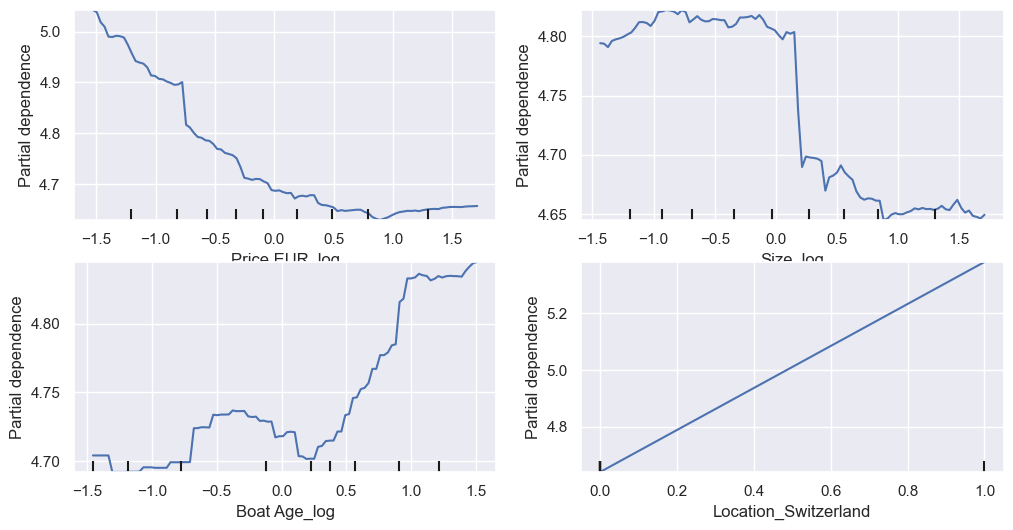

In [57]:
from sklearn.inspection import plot_partial_dependence

# Plot the features we want to 
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
plot_partial_dependence(best_forest, X, features=["Price EUR_log"], ax=axs[0,0])
plot_partial_dependence(best_forest, X, features=["Boat Age_log"], ax=axs[1, 0])
plot_partial_dependence(best_forest, X, features=["Size_log"], ax=axs[0, 1])
plot_partial_dependence(best_forest, X, features=["Location_Switzerland"], ax=axs[1, 1])
plt.show()

From the plot we can se a couple thing.

- **Price 💸:** As the price of a boat increases, the number of views it receives decreases almost linearly.
- **Size 📏:** Boat size doesn't significantly impact views until it exceeds a certain threshold, after which views drop.
- **Boat age 🛥️:** Newer boats get fewer views compared to older boats, with very old boats being particularly popular.
- **Location_switzerland 🏔️:**  Boats in Switzerland receive more views than the average boat. 

# Summary

1. Data Import and Validation:
- **Dataset Overview:** The dataset comprises **9,888** listings spread across **10** distinct features. <br>
- **Validation:** The initial data structure aligned with the expectations. However, to make this dataset suitable for machine learning models, some cleaning and feature engineering were necessary.

2. Data Cleaning:
- **Missing Values:** Detected in 'Manufacturer', 'Material', 'Length', 'Width', and 'Location'. Numeric values were filled using the median to avoid the influence of outliers, while categorical gaps were initially filled with 'Unknown'. <br>
- **Manufacturer:** Redundant 'power boats' suffix was removed, and the feature was eventually dropped due to its high cardinality.<br>
- **Location:** Simplified naming conventions and reduced the number of categories for more effective modeling.

3. Feature Engineering:
- **Type:** This column was split into two separate features, 'Condition' and 'Fuel Type', to simplify data interpretation.<br>
- **Year Built:** Anomalies (0) in this column were addressed, and a new 'Boat Age' feature was calculated to replace this.<br>
- **Price:** Standardized to EUR for uniformity. The original 'Price' column was subsequently dropped.<br>
- **Boat Type:** Restructured to focus on the top 10 types, with all others grouped under 'Other'.

4. Exploratory Data Analysis (EDA):
Using pandas_profiling, a comprehensive exploration of the dataset was conducted. This tool provided automated alerts on data issues, and it provide visualizations of patterns without the need for extensive coding.
Made it clear that we where dealing with skeewd data, as well as, high cardinality. It also revealed the correlation between features. Notable insights included data skewness, high cardinality, and revealing correlations between features.

5. Feature Transformation:
- **Size:** A new feature derived from the multiplication of 'Length' and 'Width', given their high correlation. <br>
- **Normalization:** Numeric features were log-transformed to address skewness and scaled to ensure no feature was overweighted in the models. <br>
- **Encoding:** Categorical data was transformed using OneHotEncoding to ensure model compatibility.

5. Model Building: <br>
The objective of this phase was to identify a model that accurately predicts the number of views a boat listing might receive.

- **KNN**: Achieved a Test MAPE of 44.82%
- **SVM**: Achieved a Test MAPE of 43.94%
- **Decision Tree**: Achieved a Test MAPE of 48.81%
- **Random Forest**: Achieved a Test MAPE of 44.53%

All models successfully met the project's success criteria, with their Mean Absolute Percentage Errors (MAPE) being below the 50% threshold.

Considering the project's objective — to prevent listings with low view counts and optimize website engagement — the **Random Forest** model emerges as the winner. Beyond its competitive 44.53% MAPE, Random Forest's feature_importance_ method identified the top drivers of listing views:

- Location (Switzerland, France, Germany)
- Price
- Size
- Age

With the help of Partial Dependence Plots (PDP), we could further interpret the model's internal reasoning:
- **Price 💸:** As the price of a boat increases, the number of views it receives decreases almost linearly.
- **Size 📏:** Boat size doesn't significantly impact views until it exceeds a certain threshold, after which views drop.
- **Boat age 🛥️:** Newer boats get fewer views compared to older boats, with very old boats being particularly popular.
- **Location_switzerland 🏔️:**  Boats in Switzerland receive more views than the average boat. 

## Recommendations

**Model improvements**:
- Retrain the model periodically to keep up with emerging trends.
- Enhance accuracy through additional hyperparameter tuning.
- Analyze geographical patterns to inform targeted marketing strategies.
**Data collection process**:
- Collect boat condition and fuel type as separate fields to simplify preprocessing.
- Restrict location input to letters to avoid cleaning special characters.
- Separate country and city fields for more straightforward standardization.
- Ensure boat type is captured as a single category or use multiple columns for multi-category boats.
**Feature engineering**:
- Derive boat age on input to minimize transforms needed.
- Standardize price/currency during collection to avoid later manipulation.

Improving the data collection process will reduce the need for extensive preprocessing and cleaning. Capturing labels, text, and numerical data in modeling-ready formats upfront will allow faster iteration and retraining.

## Conclusion
The view prediction model provides actionable insights Nearly New Nautical can use to optimize inventory and boost views. The project successfully met the business criteria. The next steps would be to create a pipeline to automate the process of retraining the model, and continue improvements.